In [1]:
import numpy as np
from driving.env import *
from matplotlib import pyplot as plt
import random
from ipywidgets import interactive

In [2]:
oval = make_oval()
env = DrivingEnv(dt=0.5)

def policy(s):
    d, a = oval.distance_angle_deg(s[0], s[1], s[2])
    if random.random() < 0.8:
       return 30.0*(random.random()-0.5)
    return -100*d - 2*a + 10.0*np.random.normal()
    # return 0.0
    

## Run this in stable baselines

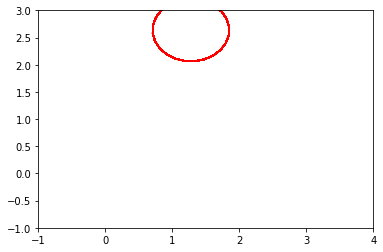

In [11]:
from stable_baselines.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines import DQN

def env_constructor():
    return DrivingEnv(dt=0.5)

env = DummyVecEnv([lambda: env_constructor()])  # The algorithms require a vectorized environment to run

model = DQN('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=10000)

def q_func_policy(s):
    return model.predict(s)[0]

def plot_value_function(q_func):
    x = np.linspace(-1.0, 4.0, 50)
    y = np.linspace(-1.0, 3.0, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.empty(X.shape)
    history = sim(q_func_policy)
#     for i in range(Z.shape[0]):
#         for j in range(Z.shape[1]):
#             x = X[i,j]
#             y = Y[i,j]
#             # d, a = oval.distance_angle(x, y, 0.0)
#             act_vals = model([x, y, 90.0])
#             if i==0 and j==0:
#                 print(act_vals)
#             r_estim = act_vals[0][actions.index(0.0)]
#             # Uncomment these lines to plot the comparison with the true reward
# #             r_true = env.reward(np.array((x,y,90.0)), 0.0) / reward_norm_val

# #             Z[i,j] = np.abs(r_estim - r_true)
#             Z[i, j] = r_estim
    #plt.contourf(X,Y,Z)
    xs = [step[0][0] for step in history]
    ys = [step[0][1] for step in history]
    plt.plot(xs, ys, color='red')
    plt.xlim([-1.0, 4.0])
    plt.ylim([-1.0, 3.0])
    #plt.colorbar()
    plt.show()

plot_value_function(model)

In [7]:
def sim(policy, n_steps=1000):
    env = DrivingEnv()
    s = env.reset()
    history = []
    for i in range(n_steps):
        a = policy(s)
        sp, r, done, info = env.step(a)
        history.append((s, a, r, sp))
        s = sp
    return history

def showmodel(model, theta=0.0, a=0.0):
    N = 20

    x = np.linspace(-1.0, 4.0, N)
    y = np.linspace(-1.0, 3.0, N)
    X, Y = np.meshgrid(x, y)
    Z = np.empty(X.shape)
    sa = np.empty((Z.size, 4))
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x = X[i,j]
            y = Y[i,j]
            sa[i*Z.shape[1]+j, :] = np.array((x, y, theta, a))

    qs = np.clip(model.predict(sa), -100.0, 0.0)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i,j] = qs[i*Z.shape[1]+j].item()

    plt.contourf(X,Y,Z)
    plt.colorbar()

In [ ]:
history = sim(policy)

In [ ]:
N = 100
x = np.linspace(-1.0, 4.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x = X[i,j]
        y = Y[i,j]
        # d, a = oval.distance_angle(x, y, 0.0)
        r = env.reward(np.array((x,y,90.0)), 0.0)
        Z[i,j] = r
plt.contourf(X,Y,Z)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
#plt.plot(xs, ys, color='red')
plt.colorbar()

In [1]:
import tensorflow as tf
deg_factor = 1/180
actions = (-30.0, -5.0, 0.0, 5.0, 30.0)
discount = 0.95
learning_rate = 0.0001

# Placeholders that we will pass the buffer elements into
state_placeholder =  tf.placeholder(dtype=tf.float32, shape=[None, 3], name="state_ph")
next_state_placeholder =  tf.placeholder(dtype=tf.float32, shape=[None, 3], name="next_state_ph")
act_placeholder = tf.placeholder(dtype=tf.int32, shape=[None], name="act_ph")
reward_placeholder = tf.placeholder(dtype=tf.float32, shape=[None], name="rew_ph")
done_placeholder = tf.placeholder(dtype=tf.float32, shape=[None], name="done_ph")


# convenience method to handle tensorflow sessions
def get_session():
    #tf.reset_default_graph()
    session = tf.Session()
    return session

# Convenience function to build a q network
def build_q_func(inputs, output_dim, name_scope, hiddens=[64, 64], reuse=False):
    with tf.variable_scope(name_scope, reuse=reuse):
            i = 1
            last_layer = inputs
            for size in hiddens:
                label = "fc{}".format(i)
                last_layer = tf.layers.dense(
                    last_layer,
                    size,
                    activation='relu',
                    #kernel_initializer=tf.random_normal_initializer(stddev=0.1),
                    name=label)
                i += 1
            output = tf.layers.dense(
                last_layer,
                output_dim,
                activation=None,
                #kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                name="fc_out")
            return output

sess = get_session()
# This is the Q function that we will optimize
q = build_q_func(state_placeholder, len(actions), "action_q", reuse=False)
# This is the target function that is used for evaluating the value of the chosen action
q_target = build_q_func(next_state_placeholder, len(actions), "target_q", reuse=False)
# This function is used to actually select the next action. I've implemented double Q learning here
# in the hopes that this makes the students code train faster
#q_copy = build_q_func(state_placeholder, len(actions), "action_q", reuse=True)
# We pull out the variables so that we can restrict the training to just the q func vars
q_func_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="action_q")
# We pull out the target variables so that we can occasionally copy over the q function variables
# onto the target variables.
target_q_func_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="target_q")

# find the target reward
# Here the expression we are computing is 
# r(s,a) + Q_target(s', argmax_a Q(s', a)) which is the double q learning expression
# hot = tf.one_hot(tf.argmax(q_copy, axis=1), len(actions))
# one-hot-encode the actions that were taken so you can select out the correct target action
hot = tf.one_hot(tf.argmax(q_target, axis=1), len(actions))
y = reward_placeholder #+ (1 - done_placeholder) * discount * (tf.reduce_sum(tf.multiply(q_target, hot),axis=1))

acts_taken_hot = tf.one_hot(act_placeholder, depth=len(actions))
q_taken = tf.multiply(q, acts_taken_hot)
q_reduce = tf.reduce_sum(q_taken, axis = 1)
total_error = tf.reduce_mean(tf.squared_difference(q_reduce, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# here note that we only pass the q_func_vars, which prevents the optimizer for changing the weights of the
# target q network
gvs = optimizer.compute_gradients(total_error, var_list=q_func_vars)
capped_gvs = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gvs]
train_fn = optimizer.apply_gradients(capped_gvs)

# update_target_fn will be called periodically to copy Q network to target Q network
update_target_fn = []
for var, var_target in zip(sorted(q_func_vars,        key=lambda v: v.name),
                           sorted(target_q_func_vars, key=lambda v: v.name)):
    update_target_fn.append(var_target.assign(var))
update_target_fn = tf.group(*update_target_fn)



W0812 20:52:05.775590 4614923712 deprecation.py:323] From <ipython-input-1-eb4f2cd101ca>:33: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0812 20:52:05.777528 4614923712 deprecation.py:506] From /Users/eugenevinitsky/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


value of error is 226.64645385742188
The reward of this round was -384.98636902613606
[[ 0.04088214 -0.0021503   0.00252467 -0.00210031 -0.03681295]]


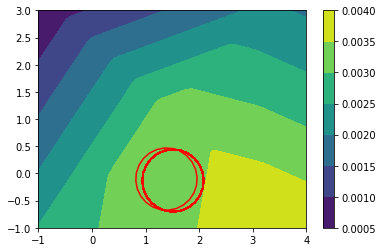

value of error is 0.07905273139476776
The reward of this round was -505.33497300119444
value of error is 0.014688041992485523
The reward of this round was -57.142598821000156
value of error is 0.011250559240579605
The reward of this round was -37.98793371187577
value of error is 0.041328251361846924
The reward of this round was -40.44329147631252
value of error is 0.00689599197357893
The reward of this round was -34.39676904216514
[[ 0.05313291 -0.01020477 -0.00744716 -0.00848328 -0.05535541]]


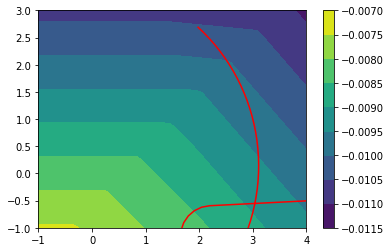

value of error is 0.016027886420488358
The reward of this round was -21.198073905765398
value of error is 0.018907032907009125
The reward of this round was -174.65904061737052
value of error is 0.006968953181058168
The reward of this round was -21.69416651904254
value of error is 0.00695129856467247
The reward of this round was -51.935971211589695
value of error is 0.011795388534665108
The reward of this round was -26.9150390545941
[[ 0.04775273 -0.01470609 -0.00912682 -0.01308765 -0.06544225]]


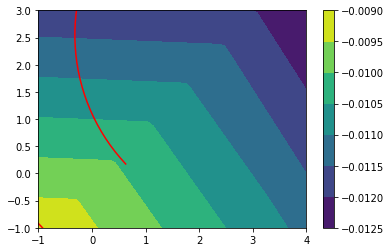

value of error is 0.01110588014125824
The reward of this round was -22.748176042141857
value of error is 0.005535523407161236
The reward of this round was -23.22103690248503
value of error is 0.0034920291509479284
The reward of this round was -62.918782642396614
value of error is 0.01179027184844017
The reward of this round was -32.480711005801815
value of error is 0.003947233781218529
The reward of this round was -20.81729718918962
[[ 0.04018182 -0.01703122 -0.01086138 -0.0157941  -0.07305011]]


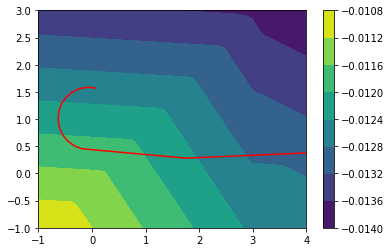

value of error is 0.008631735108792782


KeyboardInterrupt: 

In [7]:
import numpy as np

reward_norm_val = 100
obs_norm = 100.0
dist_norm_done = 10.0

def random_policy(s):
    return actions[np.random.randint(len(actions))]

def q_func_policy(s):
    q_input = np.expand_dims(s, 0)
    q_vals = sess.run(q, feed_dict={state_placeholder: q_input})
    # TODO(@evinitsky) turn the exploration schedule on
    act = np.argmax(q_vals)
    return actions[act]
        
def plot_value_function(q_func):
    x = np.linspace(-1.0, 4.0, 50)
    y = np.linspace(-1.0, 3.0, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.empty(X.shape)
    history = sim(q_func_policy)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            x = X[i,j]
            y = Y[i,j]
            # d, a = oval.distance_angle(x, y, 0.0)
            act_vals = sess.run(q, feed_dict={state_placeholder: np.array([[x, y, 90.0]]) / obs_norm})
            if i==0 and j==0:
                print(act_vals)
            r_estim = act_vals[0][actions.index(0.0)]
            # Uncomment these lines to plot the comparison with the true reward
#             r_true = env.reward(np.array((x,y,90.0)), 0.0) / reward_norm_val

#             Z[i,j] = np.abs(r_estim - r_true)
            Z[i, j] = r_estim
    plt.contourf(X,Y,Z)
    xs = [step[0][0] for step in history]
    ys = [step[0][1] for step in history]
    plt.plot(xs, ys, color='red')
    plt.xlim([-1.0, 4.0])
    plt.ylim([-1.0, 3.0])
    plt.colorbar()
    plt.show()
    
num_rollouts = 1000
# Here we pre-fill the buffer so we have something good to train with
s_buffer = np.zeros(shape=(0,3))
r_buffer = []
sp_buffer = np.zeros(shape=(0,3))
act_buffer = []
done_buffer = []
for i in range(num_rollouts):
    history = sim(random_policy, n_steps=20)
    for step in history:
#           sa = np.concatenate((step[0], (step[1],)))
#             sa_buffer = np.vstack((sa_buffer, sa*(1.0, 1.0, deg_factor, deg_factor)))
#             r_buffer.append(step[2])
#             sp_buffer.append(step[3])
          s_buffer = np.vstack((s_buffer, step[0]))
          sp_buffer = np.vstack((sp_buffer, step[3]))
          r_buffer.append(step[2] / reward_norm_val)
          # Here we store the index because the q function outputs indexes, not actions
          act_buffer.append(actions.index(step[1]))
          if np.linalg.norm(step[3][0:2]) > dist_norm_done:
              done_buffer.append(1)
          else:
              done_buffer.append(0)
          

init = tf.global_variables_initializer()
sess.run(init)
batch_size = 32
update_freq = 1000
num_iters = 100
update_index = 0
exploration_start = 0.95
exploration_rate = exploration_start
for i in range(num_iters):
    obs = env.reset()
    print_rew = 0
    state_buffer = []
    k = 0
    done=False
    while k < 1000 and done==False:
        state_buffer.append(obs)
        # compute the action
        q_input = np.expand_dims(obs, 0)
        q_vals = sess.run(q, feed_dict={state_placeholder: q_input})
        # with probability prob we take a random action, with probability 1 - prob we take a greedy action
        prob = np.random.uniform(1)
        if prob < exploration_rate:
            act = np.random.randint(len(actions))
        else:
            act = np.argmax(q_vals)
        exploration_rate = exploration_start - (update_index / 1e6)
        exploration_rate = max(0.02, exploration_rate)
        next_state, reward, done, _ = env.step(actions[act])
        if np.linalg.norm(next_state[0:2]) > dist_norm_done:
            done = True
        print_rew += reward / reward_norm_val
#         s_buffer = np.vstack((s_buffer, obs / obs_norm))
#         sp_buffer = np.vstack((sp_buffer, next_state / obs_norm))
#         r_buffer.append(reward / reward_norm_val)
#         act_buffer.append(act)
#         done_buffer.append(done)
        obs = next_state
        
        # now we do a training step on some random set of states from the buffer
        indices = np.random.randint(low=0, high=len(r_buffer), size=batch_size)
        # construct the placeholder to batch mapping
        feed_dict = {
                state_placeholder: s_buffer[indices],
                act_placeholder: np.array(act_buffer)[indices],
                reward_placeholder: np.array(r_buffer)[indices],
                next_state_placeholder: sp_buffer[indices],
                done_placeholder: np.array(done_buffer)[indices]
            }
        error = sess.run(total_error, feed_dict)
        q_func = sess.run(q, feed_dict)
        #print('q values are {}'.format(q_func))
        if k == 0:
            print('value of error is {}'.format(error))
        #print('the rewards were {}'.format(np.array(r_buffer)[indices]))
        sess.run(train_fn, feed_dict)
        # Now if enough time-steps have passed we copy the q function over into the target
        if update_index > update_freq and update_index % update_freq == 0:
            sess.run(update_target_fn)
        update_index += 1
        k += 1
    #plot_value_function(q)
    print('The reward of this round was {}'.format(print_rew))
    if i % 5 == 0:
        plot_value_function(q_func)
        
#     # preallocate array for values
#     qspa = np.empty(shape=)
#     # preallocate spa
#     for a in actions:
#         for i in range(len(sp_buffer))
#             spa[i,:] = np.stack((sp_buffer, ), axis=1)
#         # fill column (or row?) in model
#     # take maximum          
    
#     r_array = np.reshape(np.array(r_buffer), (len(r_buffer),1))
#     target = r_array + discount*maxq
#     model.fit(sa_buffer, target, epochs=5, batch_size=32, shuffle=True)

In [ ]:
model.predict(np.array([[1.0, 0.5, 0.0, -15.0*deg_factor]]))

In [ ]:
interactive(lambda theta, a: showmodel(model, theta*deg_factor, a*deg_factor), theta=(0,360), a=(-30.0, 30.0))

In [ ]:
N = 100
x = np.linspace(-1.0, 4.0, N)
y = np.linspace(-1.0, 3.0, N)
X, Y = np.meshgrid(x, y)
Z = np.empty(X.shape)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        x = X[i,j]
        y = Y[i,j]
        # d, a = oval.distance_angle(x, y, 0.0)
        r = env.reward(np.array((x,y,90.0)), 0.0)
        Z[i,j] = r
plt.contourf(X,Y,Z)
xs = [step[0][0] for step in history]
ys = [step[0][1] for step in history]
plt.plot(xs, ys, color='red')
plt.colorbar()